# Bài tập 2.1.4: Xây dựng cây quyết định và rừng cây trên dữ liệu Tỉtanic

## 1. Xây dựng cây quyết định

### 1.1 Import thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
import graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree


### 1.2 Load dữ liệu

In [2]:
# Load Titanic dataset
df = pd.read_csv('./data/train.csv')

# Giữ lại các cột quan trọng
features_response = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']
df = df[features_response]


### 1.3 Chuẩn bị dữ liệu

In [3]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
 7   Survived  891 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [5]:
# Điền missing values
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Encode Sex & Embarked
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)


### 1.4 Chia dữ liệu cho tập train và tập test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Survived', axis=1),
    df['Survived'],
    test_size=0.2,
    random_state=24
)


### 1.5 Xây dựng cây quyết định 

In [7]:
dt = tree.DecisionTreeClassifier(max_depth=2, random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

### 1.6 Hiển thị cây quyết định với package graphviz

In [8]:


dot_data = tree.export_graphviz(
    dt,
    out_file=None,
    filled=True,
    rounded=True,
    feature_names=X_train.columns,
    class_names=['Not Survived', 'Survived'],
    proportion=True
)
graph = graphviz.Source(dot_data)
graph
graph.render(view=True)


'Source.gv.pdf'

## 2. Tim tham số tối ưu cho cây quyết dịnh và vẽ biểu đồ đánh giá mô hình

### 2.1 Tạo cây quyết định và xác định các giá trị tham số có thể chọn

- `scoring='roc_auc'`: GridSearchCV chọn mô hình có khả năng phân biệt giữa 2 lớp tốt nhất (theo xác suất dự đoán), thay vì chỉ xét độ chính xác (accuracy)
- `cv = 4`: dùng để kiểm định chéo (cross-validation), dữ liệu được chia thành 4 phần bằng nhau (3 phần train, 1 phần test) -> Giúp giảm thiên lệch (bias) do chia dữ liệu ngẫu nhiên, và đánh giá mô hình ổn định, khách quan hơn
- `return_train_score=True`: để đánh giá bias và variance, GridSearchCV sẽ lưu lại cả điểm đánh giá trên tập huấn luyện (train) bên cạnh điểm trên tập kiểm định (validation).


In [9]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth': [1, 2, 4, 6, 8, 10, 12]}
cv = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),
    param_grid=params,
    scoring='roc_auc',
    refit=True,
    cv=4,
    verbose=1,
    return_train_score=True
)
cv.fit(X_train, y_train)


Fitting 4 folds for each of 7 candidates, totalling 28 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 4, 6, 8, 10, 12]},
             return_train_score=True, scoring='roc_auc', verbose=1)

### 2.2 Vẽ biểu đồ đánh giá mô hình với các tham số chiều sâu của cây khác nhau

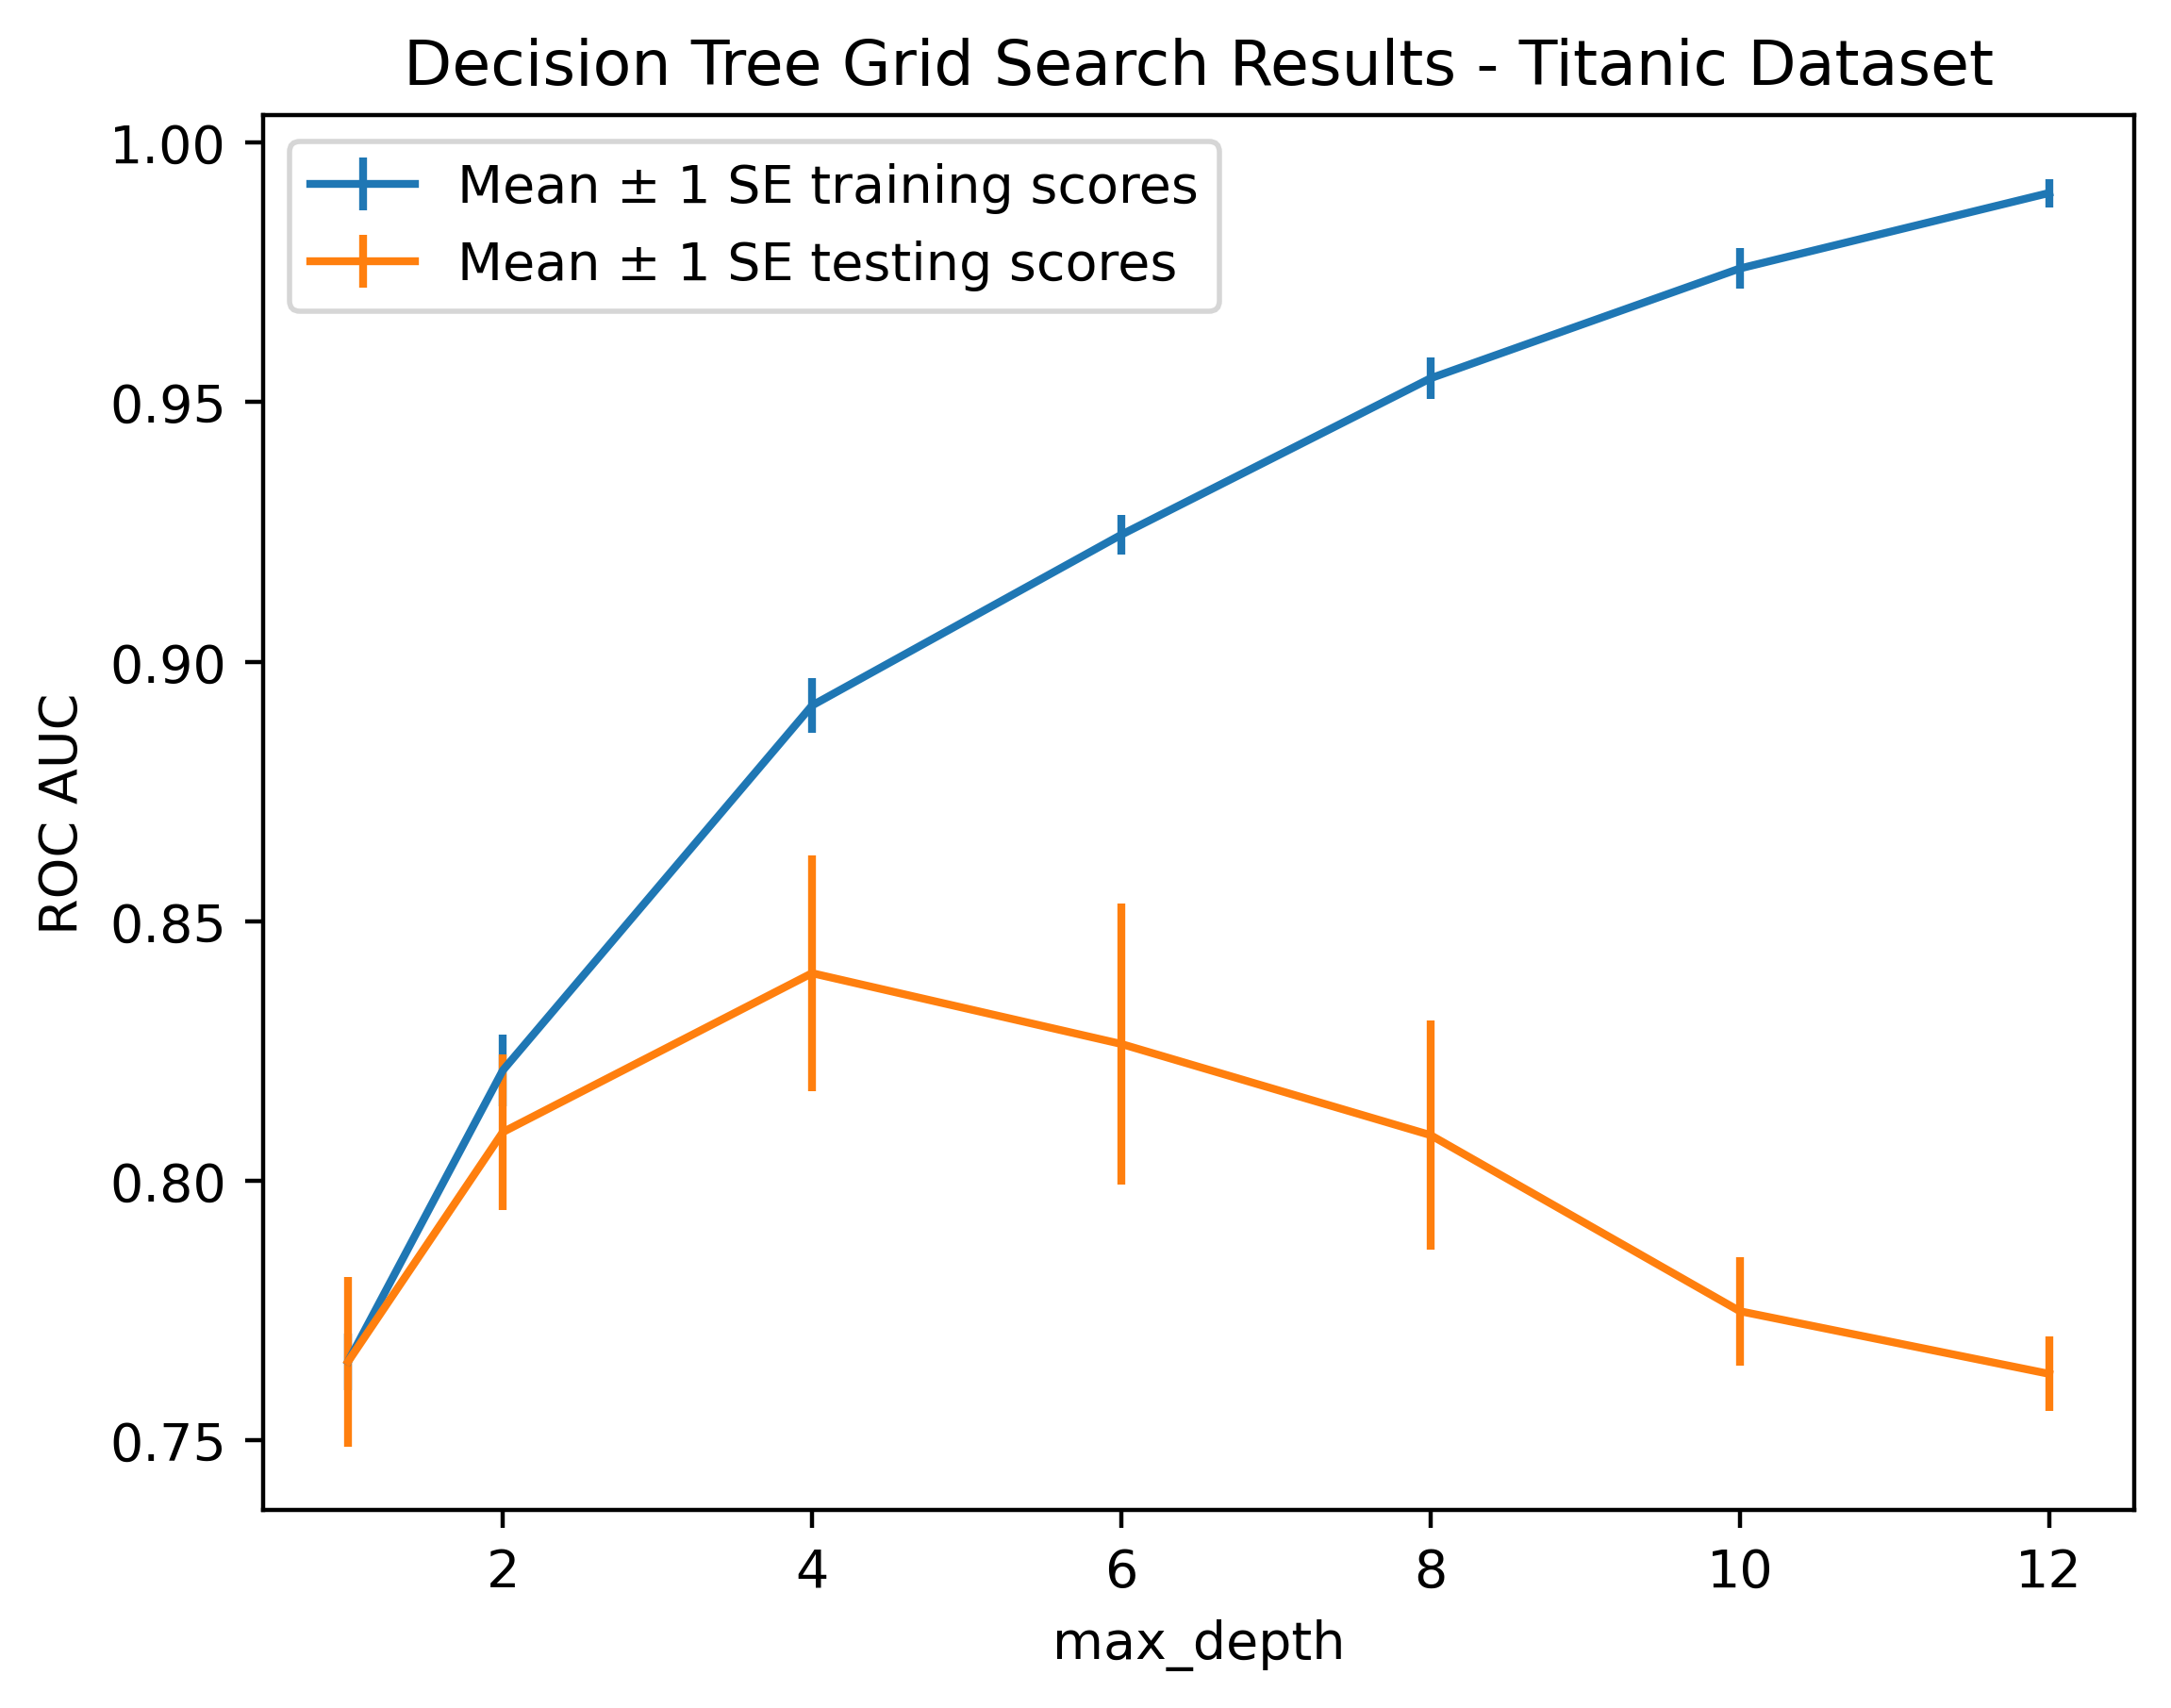

In [10]:
cv_results_df = pd.DataFrame(cv.cv_results_)
ax = plt.axes()
ax.errorbar(
    cv_results_df['param_max_depth'],
    cv_results_df['mean_train_score'],
    yerr=cv_results_df['std_train_score']/np.sqrt(4),
    label='Mean ± 1 SE training scores'
)
ax.errorbar(
    cv_results_df['param_max_depth'],
    cv_results_df['mean_test_score'],
    yerr=cv_results_df['std_test_score']/np.sqrt(4),
    label='Mean ± 1 SE testing scores'
)
ax.legend()
plt.xlabel('max_depth')
plt.ylabel('ROC AUC')
plt.title('Decision Tree Grid Search Results - Titanic Dataset')
plt.show()


## 3. Xây dựng rừng cây (random forest)

### 3.2 Tạo rừng cây với lớp RandomForestClassifier

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=10,
    criterion='gini',
    max_depth=3,
    random_state=42
)
rf_params = {'n_estimators': list(range(10, 110, 10))}


### 3.3 Tìm tham số tối ưu cho mô hình rừng cây và thực hiện train với tham số tối ưu đó

In [12]:

cv_rf = GridSearchCV(
    rf,
    param_grid=rf_params,
    scoring='roc_auc',
    cv=4,
    verbose=1,
    return_train_score=True
)
cv_rf.fit(X_train, y_train)


Fitting 4 folds for each of 10 candidates, totalling 40 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=42),
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             return_train_score=True, scoring='roc_auc', verbose=1)

### 3.4 Vẽ biểu đồ đánh giá mô hình rừng cây với các tham số số cây có trong rừng khác nhau

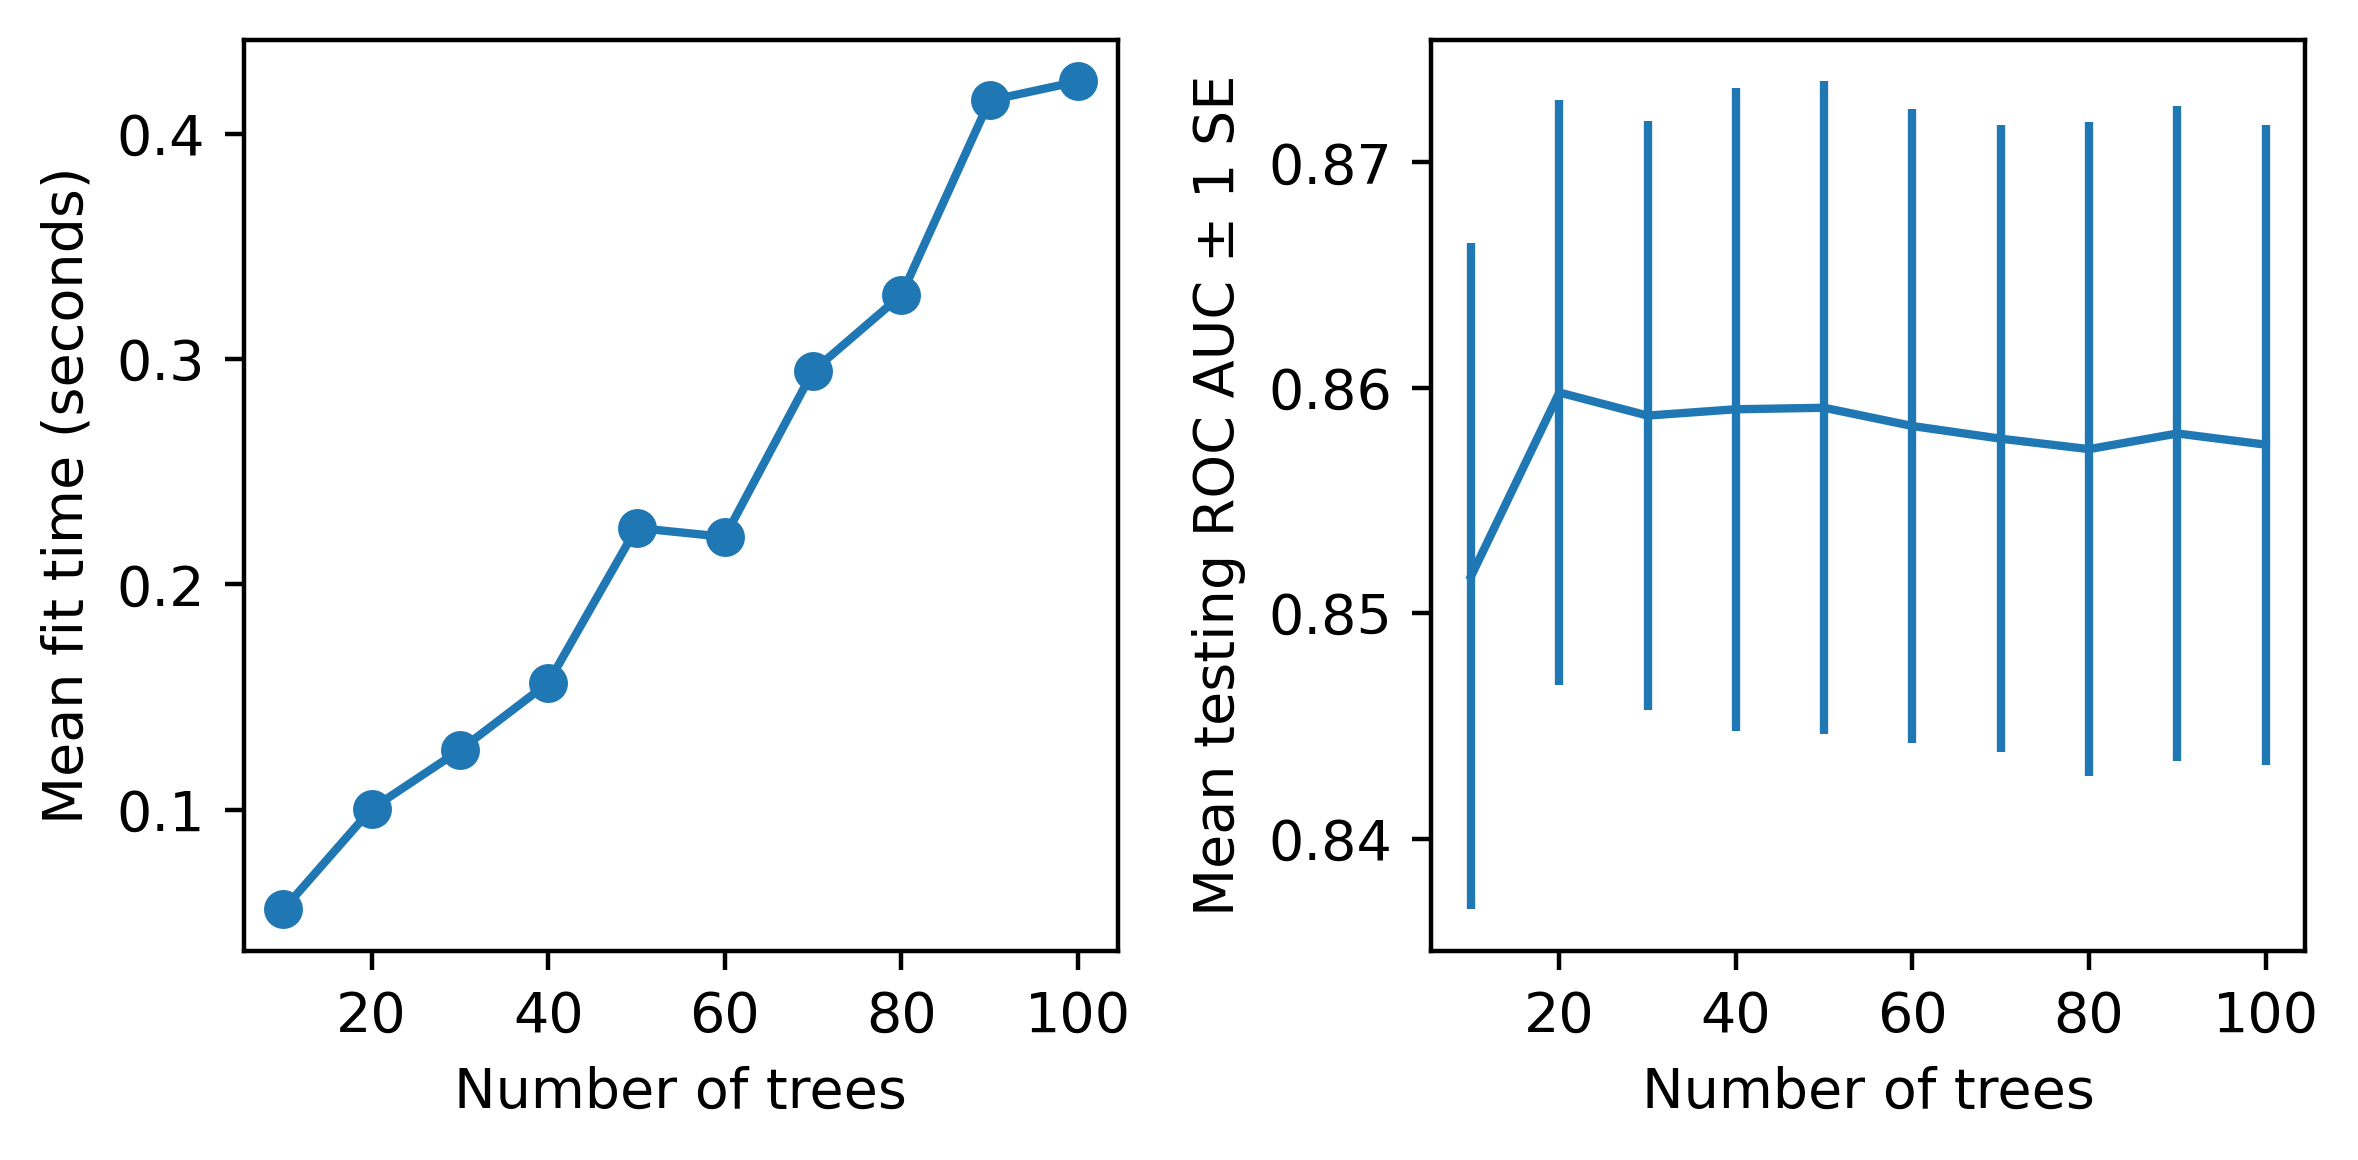

In [13]:
cv_rf_df = pd.DataFrame(cv_rf.cv_results_)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].plot(cv_rf_df['param_n_estimators'], cv_rf_df['mean_fit_time'], '-o')
axs[0].set_xlabel('Number of trees')
axs[0].set_ylabel('Mean fit time (seconds)')

axs[1].errorbar(cv_rf_df['param_n_estimators'],
                cv_rf_df['mean_test_score'],
                yerr=cv_rf_df['std_test_score']/np.sqrt(4))
axs[1].set_xlabel('Number of trees')
axs[1].set_ylabel('Mean testing ROC AUC ± 1 SE')
plt.tight_layout()
plt.show()


### 3.5 Xem tham số tốt nhất và mức độ quan trọng của từng feature trong mô hình với tham số tốt nhất

Best params: {'n_estimators': 20}


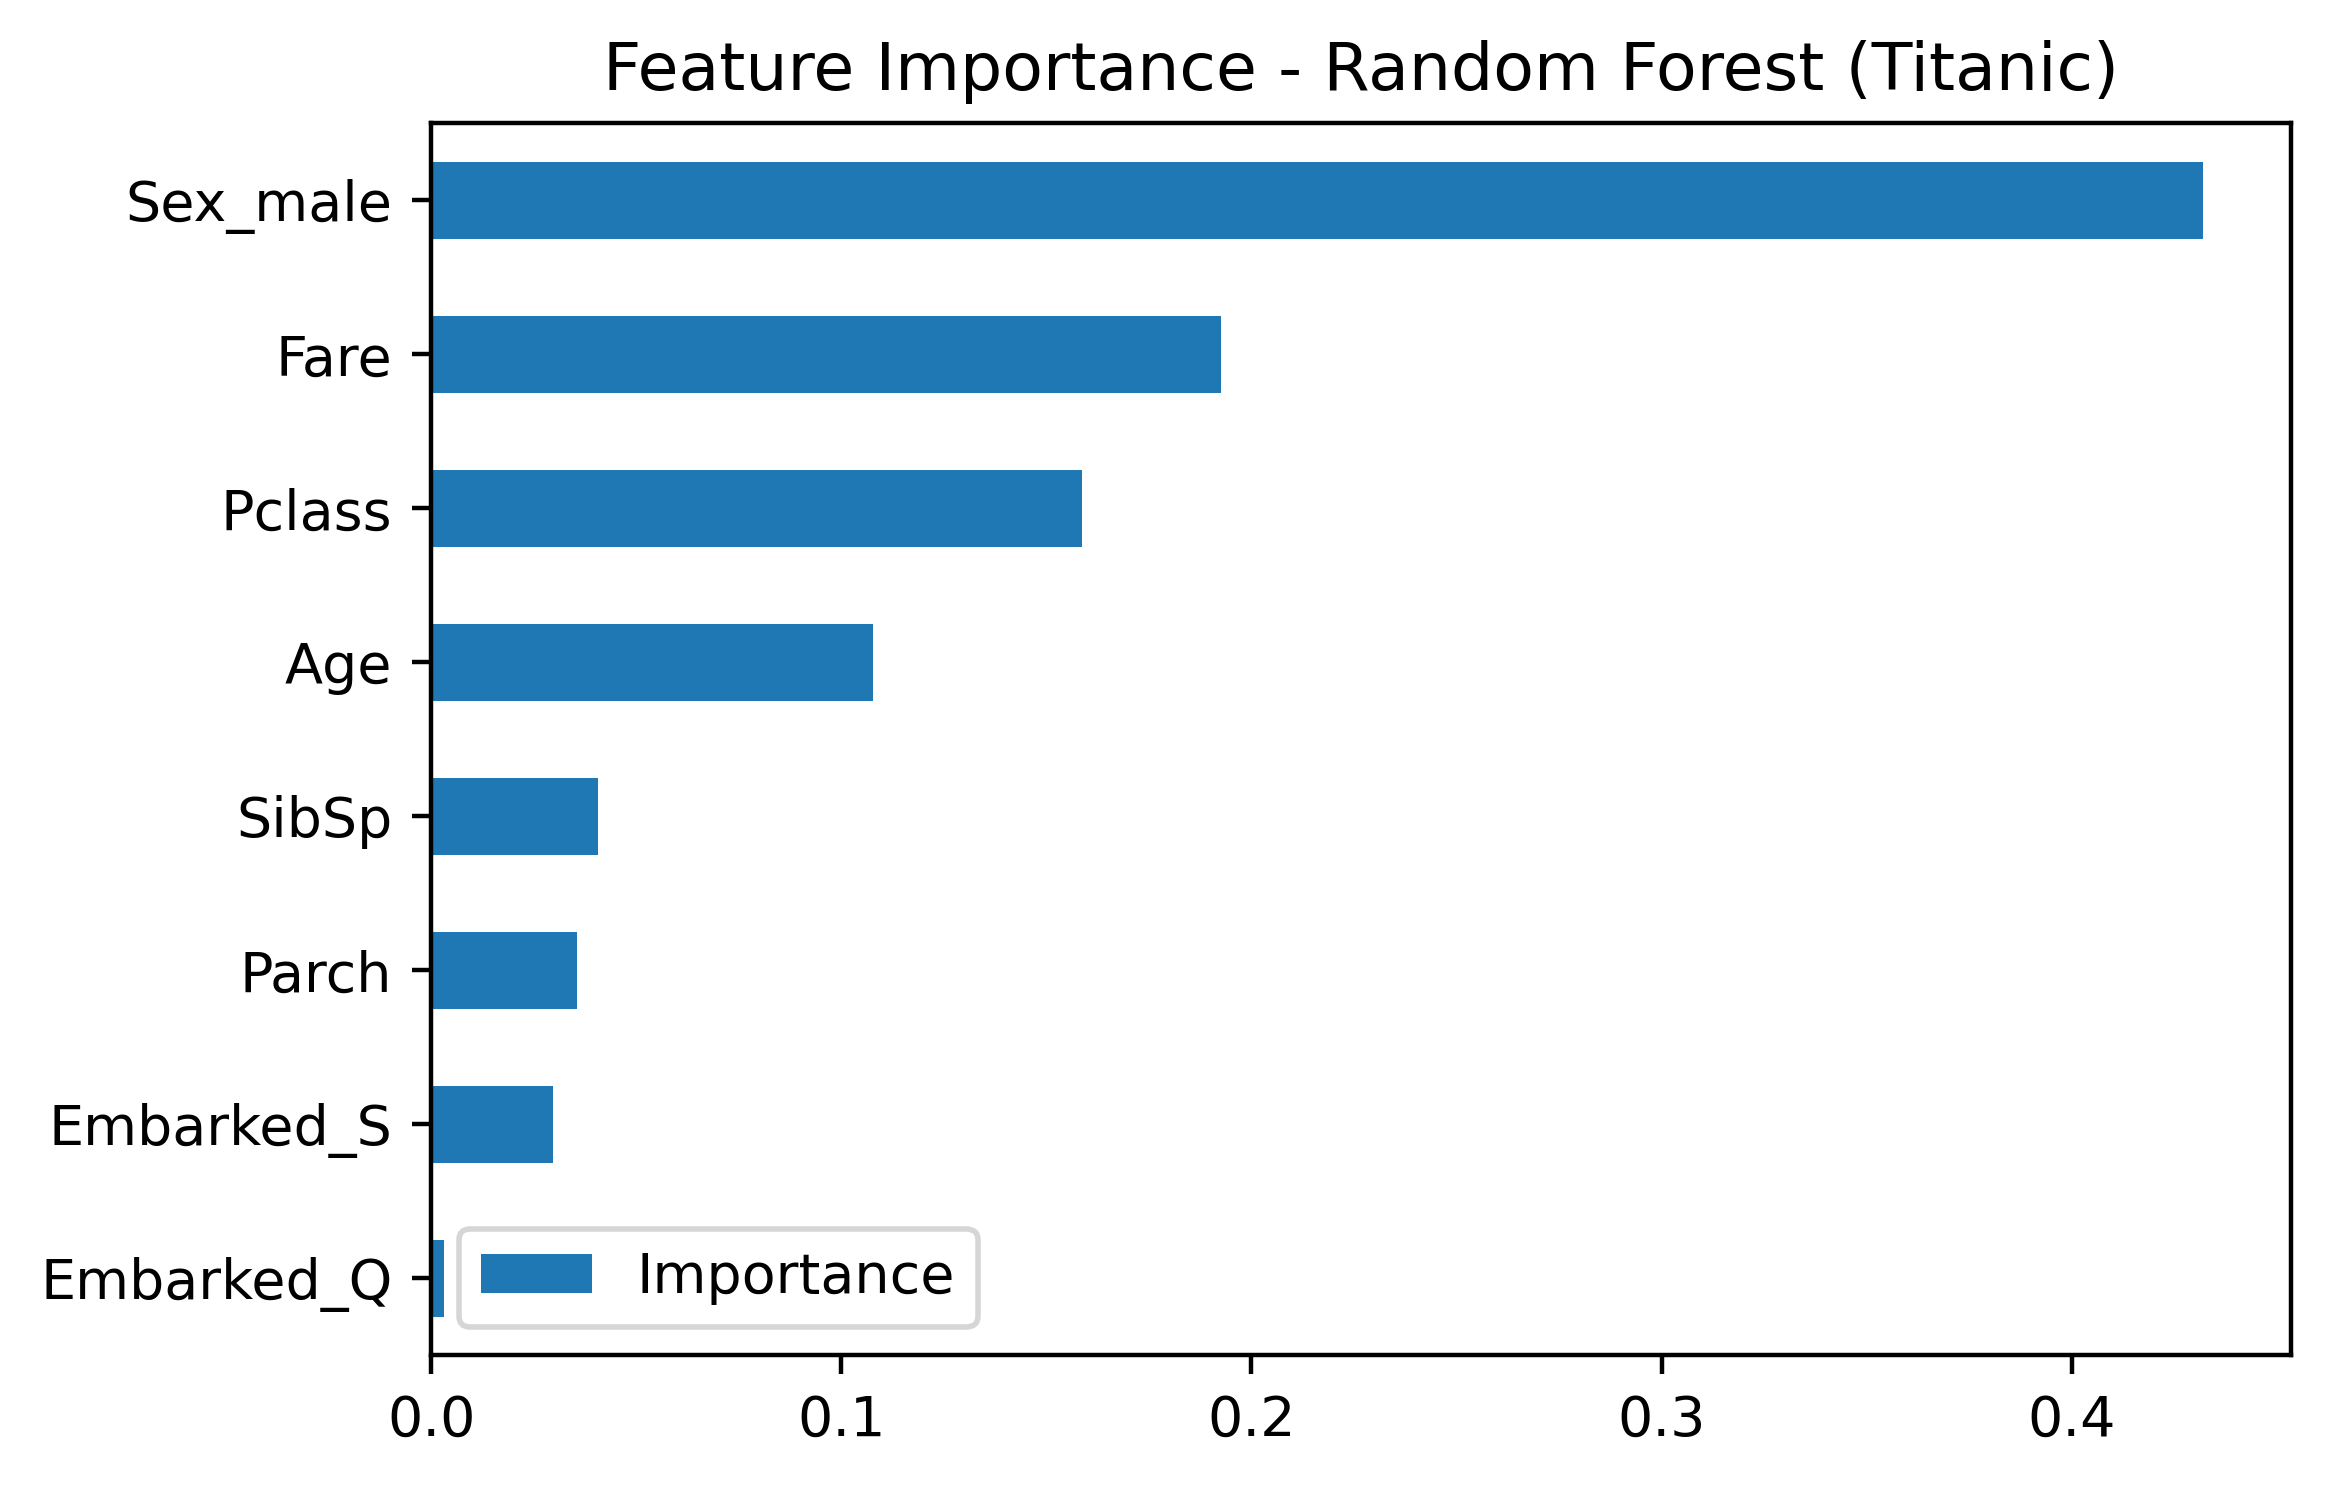

In [14]:
print("Best params:", cv_rf.best_params_)

feat_imp_df = pd.DataFrame({
    'Importance': cv_rf.best_estimator_.feature_importances_
}, index=X_train.columns)
feat_imp_df.sort_values('Importance', ascending=True).plot.barh(figsize=(6,4))
plt.title('Feature Importance - Random Forest (Titanic)')
plt.show()


# Kết thúc